# SGD Mnist

En este notebook vamos a realizar un ejercicio de clasificación utilizando una red neuronal convolucional y el sistema SGD (*Sthocastic Gradient Descent*) sobre el dataset Mnist.

Empezamos con un *Magic Command* para que los gráficos permanezcan en guardados en el notebook.

In [1]:
%matplotlib inline

Desde la librería *fastai* importamos todo el módulo *basics*.

In [2]:
from fastai.basics import *

En 'path' creamos la ruta de acesso al dataset '[Mnist](http://deeplearning.net/data/mnist/mnist.pkl.gz)'.

In [9]:
path = Config().data_path()/'mnist'

In [10]:
path.ls()

[PosixPath('/storage/mnist/mnist.pkl.gz')]

Con 'gzip.open' descomprimimos y abrimos el archivo del dataset. Cargamos los datos en los respectivos *train dataset* y *validation dataset* con la función 'pickle.load' codificando el contenido como 'latin-1'

In [14]:
with gzip.open(path/'mnist.pkl.gz', 'rb') as f:
    ((x_train, y_train), (x_valid, y_valid), _) = pickle.load(f, encoding='latin-1')

Mostramos la primera entrada del *train dataset* redimensionado a 28x28 y en escala de grises. También mostramos el tamaño de 'x_train'.

(50000, 784)

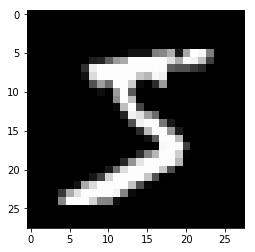

In [17]:
plt.imshow(x_train[0].reshape((28,28)),cmap="gray")
x_train.shape

Con 'map(torch.tensor())' copiamos el valor de dichos tensores en la respectivas variables. Mostramos el tensor mínimo y máximo de 'y_train', en este caso '0' y ' 9'.

In [18]:
x_train, y_train, x_valid, y_valid = map(torch.tensor, (x_train, y_train, x_valid, y_valid))
n, c = x_train.shape
x_train.shape, y_train.min(), y_train.max()

(torch.Size([50000, 784]), tensor(0), tensor(9))

Creamos el *databunch*. Elegimos un *batch size* de 64, con la función 'TensorDataset' con vertimos los tensores de 'train' y valid' en datasets. Finalmente, almacenamos el *databunch* en 'data'.

In [20]:
bs = 64
train_ds = TensorDataset(x_train, y_train)
valid_ds = TensorDataset(x_valid, y_valid)
data = DataBunch.create(train_ds, valid_ds, bs=bs)

En 'x', e 'y' guardamos la matriz de entrenamiento y el vector target de 'train_dl'.

In [21]:
x, y = next(iter(data.train_dl))
x.shape, y.shape

(torch.Size([64, 784]), torch.Size([64]))

Empleando las funciones de Pytorch, creamos una clase llamada 'Mnist_Logistic()' para crear nuestra propia red neuronal. En este caso será una transformación lineal, con un tamaño de entrada de 784, que es tamaño de nuestra matriz de entrenamiento, y una tamaño del vector de salida de 10, para referirnos a los números desde el '0' al '9'. También creamos el ´bias' de la capa.

In [22]:
class Mnist_Logistic(nn.Module):
    def __init__(self):
        super().__init__()
        self.lin = nn.Linear(784, 10, bias=True)
        
    def forward(self, xb): return self.lin(xb)

Con la función '.cuda()' seleccionamos GPU como dispositivo de entrenamiento.

In [23]:
model = Mnist_Logistic().cuda()

Mostramos cómo queda el modelo.

In [24]:
model

Mnist_Logistic(
  (lin): Linear(in_features=784, out_features=10, bias=True)
)

In [25]:
model.lin

Linear(in_features=784, out_features=10, bias=True)

In [26]:
model(x).shape

torch.Size([64, 10])

In [27]:
[p.shape for p in model.parameters()]

[torch.Size([10, 784]), torch.Size([10])]

Escogemos un *learning rate* de 0.002.

In [28]:
lr = 2e-2

En 'loss_func' establecemos como función de pérdida 'CrossEntropyLoss()'.

In [29]:
loss_func = nn.CrossEntropyLoss()

Creamos una función llamada 'update' para calcular el descenso de gradiente. En primer lugar asignamos a la variable 'wd' un valor de *weight decay* de 0.00001 que cumplirá la misión de evitar el *overfitting*. En 'y_hat' almacenamos la matriz de entrada de nuestro modelo, y en 'w2' un valor inicial de '0' de tipo coma flotante. 

A continuación actualizamos el valor de 'W2' con el sumatorio del cuadrado del vaor de los pesos. En 'loss' calculamos la pérdida, con la función 'backward' realizamos la fase de *backpropagation*.

Actualizamos el valor de los pesos multiplicándolo por el *learning rate* con la función 'sub_' y ponemos el valor de los gradientes a '0' para no acumularlos y poder computar el próximo lote desde '0'. 

La función 'update' devuelve el 'loss' como un número plano.

In [32]:
def update(x,y,lr):
    wd = 1e-5
    y_hat = model(x)
    w2 = 0.
    for p in model.parameters(): w2 += (p**2).sum()
    loss = loss_func(y_hat, y) + w2 * wd
    loss.backward()
    with torch.no_grad():
        for p in model.parameters():
            p.sub_(lr * p.grad)
            p.grad.zero_()
    return loss.item()

En 'losses' pasamos a la función 'update' cada una de las entradas de 'data.train_dl'.

In [33]:
losses = [update(x,y,lr) for x,y in data.train_dl]

Gráficamos 'losses'.

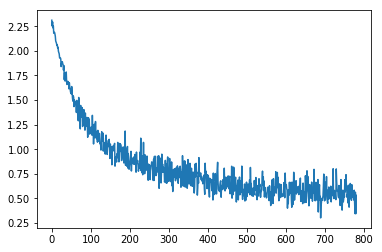

In [34]:
plt.plot(losses)

Creamos otra estructura de resd neuronal. En este caso creamos una capa de 784 x 50 con 'bias', y otra de 50 x 10 con 'bias'. Escogemos ['relu'](https://es.wikipedia.org/wiki/Rectificador_(redes_neuronales)) como función de activación.

In [40]:
class Mnist_NN(nn.Module):
    def __init__(self):
        super().__init__()
        self.lin1 = nn.Linear(784, 50, bias=True)
        self.lin2 = nn.Linear(50, 10, bias=True)
        
    def forward(self, xb):
        x = self.lin1(xb)
        x = F.relu(x)
        return self.lin2(x)

Creamos el nuevo modelo.

In [41]:
model = Mnist_NN().cuda()

Le pasamos los datos de 'train_dl' a la función 'update'. e imprimimos 'losses'.

In [42]:
losses = [update(x,y,lr) for x,y in data.train_dl]

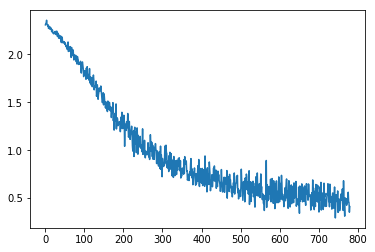

Exception ignored in: <bound method _MultiProcessingDataLoaderIter.__del__ of <torch.utils.data.dataloader._MultiProcessingDataLoaderIter object at 0x7f04133340b8>>
Traceback (most recent call last):
  File "/opt/conda/envs/fastai/lib/python3.6/site-packages/torch/utils/data/dataloader.py", line 961, in __del__
    self._shutdown_workers()
  File "/opt/conda/envs/fastai/lib/python3.6/site-packages/torch/utils/data/dataloader.py", line 941, in _shutdown_workers
    w.join()
  File "/opt/conda/envs/fastai/lib/python3.6/multiprocessing/process.py", line 124, in join
    res = self._popen.wait(timeout)
  File "/opt/conda/envs/fastai/lib/python3.6/multiprocessing/popen_fork.py", line 50, in wait
    return self.poll(os.WNOHANG if timeout == 0.0 else 0)
  File "/opt/conda/envs/fastai/lib/python3.6/multiprocessing/popen_fork.py", line 28, in poll
    pid, sts = os.waitpid(self.pid, flag)
KeyboardInterrupt: 


In [43]:
plt.plot(losses)

In [47]:
model = Mnist_NN().cuda()

Creamos una nueva función 'update' para comparar el modelo anterior con el rendimiento del optimizador '[Adam](https://machinelearningmastery.com/adam-optimization-algorithm-for-deep-learning/)'.

In [48]:
def update(x,y,lr):
    opt = optim.Adam(model.parameters(), lr)
    y_hat = model(x)
    loss = loss_func(y_hat, y)
    loss.backward()
    opt.step()
    opt.zero_grad()
    return loss.item()

Le pasamos los datos a la nueva función 'update' con un *learning rate* de 0.001.

In [49]:
losses = [update(x,y,1e-3) for x,y in data.train_dl]

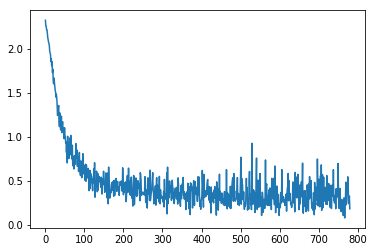

In [50]:
plt.plot(losses)

Creamos un modelo con los datos empleados anteriormente, la estructura neuronal ' Mnist_NN', 'loss_func' y 'accuracy' como métrica de rendimiento.

In [51]:
learn = Learner(data, Mnist_NN(), loss_func=loss_func, metrics=accuracy)

Con el [*magic command*](https://ipython.readthedocs.io/en/stable/interactive/magics.html)  '%debug' pasamos el modelo por un depurador para ver si tiene algún problema.

In [52]:
%debug

> /opt/conda/envs/fastai/lib/python3.6/site-packages/torch/nn/modules/module.py(96)forward()
     94             registered hooks while the latter silently ignores them.
     95         """
---> 96         raise NotImplementedError
     97 
     98     def register_buffer(self, name, tensor):

ipdb> print(k)
*** NameError: name 'k' is not defined
ipdb> u
> /opt/conda/envs/fastai/lib/python3.6/site-packages/torch/nn/modules/module.py(532)__call__()
    530             result = self._slow_forward(*input, **kwargs)
    531         else:
--> 532             result = self.forward(*input, **kwargs)
    533         for hook in self._forward_hooks.values():
    534             hook_result = hook(self, input, result)

ipdb> print(k)
*** NameError: name 'k' is not defined
ipdb> q


Realizamos la busqueda del 'lr' y lo graficamos.

epoch,train_loss,valid_loss,accuracy,time


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


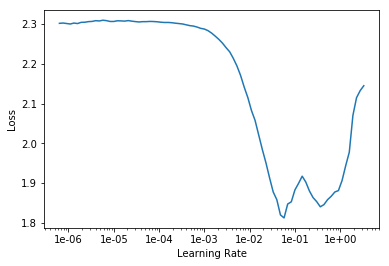

In [53]:
learn.lr_find()
learn.recorder.plot()

Entrenamos el modelo con un 'lr' de 0.01 durante una época.

In [54]:
learn.fit_one_cycle(1, 1e-2)

epoch,train_loss,valid_loss,accuracy,time
0,0.137855,0.126954,0.965400,00:03


Graficamos el *learning rate*, el *momentum* y *losses*.

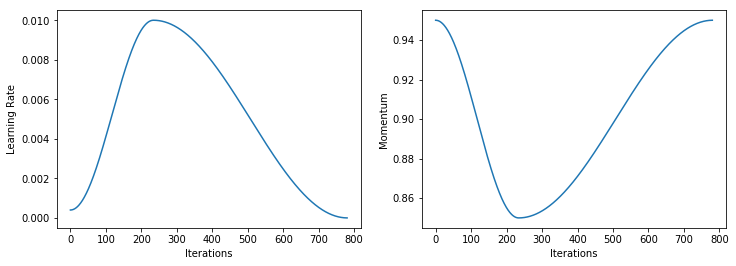

In [55]:
learn.recorder.plot_lr(show_moms=True)

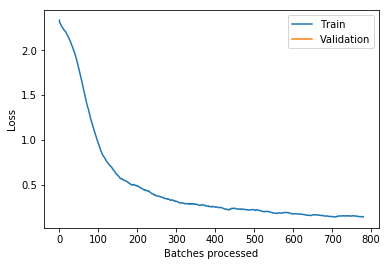

In [56]:
learn.recorder.plot_losses()